In [ ]:
# ttt_transformer_teacher_colab_metrics.py
# Full regenerated version of your original code + extensive metrics + inline plots for Colab.

import os
import math
import random
import time
from dataclasses import dataclass, asdict
from typing import Dict, List, Tuple, Optional
from collections import deque

import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm.auto import trange, tqdm

import matplotlib.pyplot as plt

try:
    import pandas as pd
except Exception:
    pd = None


In [ ]:
# -------------------------
# 0) Device + seeds
# -------------------------
def pick_device():
    if torch.cuda.is_available():
        return torch.device("cuda")
    if hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
        return torch.device("mps")
    return torch.device("cpu")

def set_seed(seed: int):
    random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)


In [ ]:
# -------------------------
# 1) TicTacToe rules
# board is list[int] length 9 in {-1,0,+1}
# player is +1 or -1 (side to move)
# -------------------------
WIN_LINES = [
    (0,1,2),(3,4,5),(6,7,8),
    (0,3,6),(1,4,7),(2,5,8),
    (0,4,8),(2,4,6)
]

def winners_set(board: List[int]) -> set:
    wins = set()
    for a,b,c in WIN_LINES:
        s = board[a] + board[b] + board[c]
        if s == 3:
            wins.add(+1)
        elif s == -3:
            wins.add(-1)
    return wins

def is_terminal(board: List[int]) -> Tuple[bool, int]:
    wset = winners_set(board)
    if len(wset) >= 2:
        # illegal board state (both win). Treat as terminal draw for safety.
        return True, 0
    if len(wset) == 1:
        return True, next(iter(wset))
    if all(v != 0 for v in board):
        return True, 0
    return False, 0

def legal_moves(board: List[int]) -> List[int]:
    return [i for i,v in enumerate(board) if v == 0]

def apply_move(board: List[int], player: int, a: int) -> List[int]:
    nb = board[:]  # copy
    nb[a] = player
    return nb

In [ ]:
# -------------------------
# 2) Exact minimax teacher (cached)
# returns:
#  v*: +1 win / 0 draw / -1 loss from CURRENT player's perspective
#  best_moves: list of moves that achieve v*
# -------------------------
_MINIMAX_CACHE: Dict[Tuple[Tuple[int,...], int], Tuple[int, Tuple[int,...]]] = {}

def minimax_value_and_moves(board: List[int], player: int) -> Tuple[int, List[int]]:
    key = (tuple(board), player)
    if key in _MINIMAX_CACHE:
        v, best = _MINIMAX_CACHE[key]
        return v, list(best)

    done, winner = is_terminal(board)
    if done:
        if winner == 0:
            v = 0
        elif winner == player:
            v = +1
        else:
            v = -1
        _MINIMAX_CACHE[key] = (v, tuple())
        return v, []

    best_v = -2
    best_moves: List[int] = []
    for a in legal_moves(board):
        nb = apply_move(board, player, a)
        child_v, _ = minimax_value_and_moves(nb, -player)
        v_here = -child_v
        if v_here > best_v:
            best_v = v_here
            best_moves = [a]
        elif v_here == best_v:
            best_moves.append(a)

    _MINIMAX_CACHE[key] = (best_v, tuple(best_moves))
    return best_v, best_moves

def teacher_policy(board: List[int], player: int) -> Tuple[torch.Tensor, torch.Tensor]:
    """
    Returns:
      pi*: [9] float (uniform over optimal moves, 0 elsewhere)
      v*:  scalar float in {-1,0,+1}
    """
    v, best = minimax_value_and_moves(board, player)
    pi = torch.zeros(9, dtype=torch.float32)
    if best:
        pi[best] = 1.0 / len(best)
    return pi, torch.tensor(float(v), dtype=torch.float32)


In [ ]:
# -------------------------
# 3) Perspective token encoding for the model
# empty=0, self=1, opp=2  (relative to current player)
# -------------------------
def board_to_tokens_perspective(board: List[int], player: int) -> torch.LongTensor:
    toks = []
    for v in board:
        pv = v * player
        if pv == 0:   toks.append(0)
        elif pv == 1: toks.append(1)
        else:         toks.append(2)
    return torch.tensor(toks, dtype=torch.long)

def legal_mask_from_board(board: List[int]) -> torch.BoolTensor:
    m = torch.zeros(9, dtype=torch.bool)
    for i,v in enumerate(board):
        if v == 0:
            m[i] = True
    return m

def masked_log_softmax(logits: torch.Tensor, legal_mask: torch.Tensor) -> torch.Tensor:
    masked = logits.masked_fill(~legal_mask, -1e9)
    return F.log_softmax(masked, dim=-1)

def masked_softmax(logits: torch.Tensor, legal_mask: torch.Tensor) -> torch.Tensor:
    masked = logits.masked_fill(~legal_mask, -1e9)
    return F.softmax(masked, dim=-1)

In [ ]:
# -------------------------
# 4) Symmetry augmentation (8 transforms)
# new[i] = old[MAP[i]] where i is transformed position
# -------------------------
def _idx(r, c): return r*3 + c

def _build_maps():
    maps = []
    for k in range(8):
        mp = [0]*9
        for r in range(3):
            for c in range(3):
                if k == 0:   rt, ct = r, c
                elif k == 1: rt, ct = c, 2-r
                elif k == 2: rt, ct = 2-r, 2-c
                elif k == 3: rt, ct = 2-c, r
                elif k == 4: rt, ct = r, 2-c
                elif k == 5: rt, ct = 2-r, c
                elif k == 6: rt, ct = c, r
                else:        rt, ct = 2-c, 2-r
                mp[_idx(rt,ct)] = _idx(r,c)
        maps.append(torch.tensor(mp, dtype=torch.long))
    return maps

SYM_MAPS = _build_maps()

def apply_sym_board(board: List[int], sym_id: int) -> List[int]:
    mp = SYM_MAPS[sym_id]
    old = board
    new = [0]*9
    for i in range(9):
        new[i] = old[int(mp[i].item())]
    return new

def apply_sym_pi(pi: torch.Tensor, sym_id: int) -> torch.Tensor:
    mp = SYM_MAPS[sym_id].to(pi.device)
    return pi.index_select(0, mp)

def apply_sym_mask(mask: torch.Tensor, sym_id: int) -> torch.Tensor:
    mp = SYM_MAPS[sym_id].to(mask.device)
    return mask.index_select(0, mp)


In [ ]:
# -------------------------
# 5) Tiny Transformer (policy + value)
# -------------------------
class TinyTTTTransformer(nn.Module):
    def __init__(self, d_model=64, n_heads=4, n_layers=2, ff_mult=4, dropout=0.0):
        super().__init__()
        self.token_emb = nn.Embedding(3, d_model)
        self.pos_emb = nn.Embedding(9, d_model)
        self.drop = nn.Dropout(dropout)

        enc_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=n_heads,
            dim_feedforward=d_model*ff_mult,
            dropout=dropout,
            activation="gelu",
            batch_first=True,
            norm_first=True,
        )
        self.encoder = nn.TransformerEncoder(enc_layer, num_layers=n_layers)
        self.policy_head = nn.Linear(d_model, 9)
        self.value_head = nn.Linear(d_model, 1)

    def forward(self, tokens: torch.LongTensor) -> Tuple[torch.Tensor, torch.Tensor]:
        B = tokens.size(0)
        pos = torch.arange(9, device=tokens.device).unsqueeze(0).expand(B, 9)
        x = self.token_emb(tokens) + self.pos_emb(pos)
        x = self.drop(x)
        x = self.encoder(x)
        pooled = x.mean(dim=1)
        logits = self.policy_head(pooled)                         # [B,9]
        value = torch.tanh(self.value_head(pooled)).squeeze(-1)   # [B]
        return logits, value

In [ ]:
# -------------------------
# 6) Replay buffers
# Each item is (tokens[9] long, legal_mask[9] bool, pi*[9] float, v* float)
# -------------------------
class PositionReplay:
    def __init__(self, max_items: int):
        self.buf = deque(maxlen=max_items)

    def __len__(self): return len(self.buf)

    def add(self, tokens, mask, pi, v):
        self.buf.append((
            tokens.cpu(),
            mask.cpu(),
            pi.cpu(),
            float(v.item()) if isinstance(v, torch.Tensor) else float(v),
        ))

    def sample(self, batch_size: int, device: torch.device):
        batch_size = min(batch_size, len(self.buf))
        items = random.sample(self.buf, batch_size)
        tokens = torch.stack([it[0] for it in items], dim=0).to(device)     # [B,9]
        mask   = torch.stack([it[1] for it in items], dim=0).to(device)     # [B,9]
        pi     = torch.stack([it[2] for it in items], dim=0).to(device)     # [B,9]
        v      = torch.tensor([it[3] for it in items], dtype=torch.float32, device=device)  # [B]
        return tokens, mask, pi, v


In [ ]:
# -------------------------
# 7) Loss + metric helpers
# -------------------------
def compute_loss_teacher(
    logits: torch.Tensor,
    values: torch.Tensor,
    legal_mask: torch.Tensor,
    pi_star: torch.Tensor,
    v_star: torch.Tensor,
    beta_entropy: float = 0.01,
    value_coef: float = 1.0,
) -> Tuple[torch.Tensor, Dict[str, float]]:
    logp = masked_log_softmax(logits, legal_mask)          # [B,9]
    probs = logp.exp()

    policy_loss = -(pi_star * logp).sum(dim=1).mean()
    value_loss = F.mse_loss(values, v_star)
    entropy = -(probs * logp).sum(dim=1).mean()

    total = policy_loss + value_coef * value_loss - beta_entropy * entropy

    return total, {
        "loss": float(total.item()),
        "pi_loss": float(policy_loss.item()),
        "v_loss": float(value_loss.item()),
        "entropy": float(entropy.item()),
    }

@torch.no_grad()
def batch_metrics(
    logits: torch.Tensor,
    values: torch.Tensor,
    legal_mask: torch.Tensor,
    pi_star: torch.Tensor,
    v_star: torch.Tensor,
) -> Dict[str, float]:
    # Model distribution over legal moves
    logp = masked_log_softmax(logits, legal_mask)   # [B,9]
    p = logp.exp()

    # Teacher "optimal set"
    best = (pi_star > 0)

    # Top-1 optimal move accuracy
    a = p.argmax(dim=1)
    top1_opt = best.gather(1, a.unsqueeze(1)).squeeze(1).float().mean().item()

    # Probability mass on optimal moves
    opt_mass = (p * best.float()).sum(dim=1).mean().item()

    # Teacher CE (same as policy loss but per batch)
    ce = (-(pi_star * logp).sum(dim=1)).mean().item()

    # KL(teacher || model): sum pi * (log pi - log p)
    # pi has zeros off-optimal set, so safe.
    eps = 1e-12
    log_pi = torch.log(torch.clamp(pi_star, min=eps))
    kl = (pi_star * (log_pi - logp)).sum(dim=1).mean().item()

    # "Perplexity-ish" of teacher CE (exp(CE))
    ppl = math.exp(min(50.0, ce))  # clamp so it doesn't explode

    # Value metrics
    v_mse = F.mse_loss(values, v_star).item()
    v_mae = F.l1_loss(values, v_star).item()
    v_round = torch.clamp(torch.round(values), -1, 1)
    v_exact = (v_round == v_star).float().mean().item()

    non_draw = (v_star != 0)
    if non_draw.any():
        v_sign_acc = (torch.sign(values[non_draw]) == torch.sign(v_star[non_draw])).float().mean().item()
    else:
        v_sign_acc = float("nan")

    # Value calibration-ish stats
    v_pred_mean = values.mean().item()
    v_pred_std = values.std(unbiased=False).item()

    # Policy confidence stats
    p_max = p.max(dim=1).values.mean().item()

    return {
        "train_top1_opt": top1_opt,
        "train_opt_mass": opt_mass,
        "train_ce": ce,
        "train_kl_t_m": kl,
        "train_ppl": ppl,
        "train_v_mse": v_mse,
        "train_v_mae": v_mae,
        "train_v_exact": v_exact,
        "train_v_sign_acc": v_sign_acc,
        "train_v_pred_mean": v_pred_mean,
        "train_v_pred_std": v_pred_std,
        "train_pmax_mean": p_max,
    }

def param_norm(model: nn.Module) -> float:
    s = 0.0
    with torch.no_grad():
        for p in model.parameters():
            if p is not None:
                s += float((p.detach()**2).sum().item())
    return math.sqrt(s)

def get_lr(opt: torch.optim.Optimizer) -> float:
    for g in opt.param_groups:
        return float(g.get("lr", 0.0))
    return 0.0


In [ ]:
# -------------------------
# 8) Self-play: collect positions (targets from teacher)
# -------------------------
@torch.no_grad()
def play_self_play_game_collect_positions(
    model: nn.Module,
    device: torch.device,
    temp: float,
    dir_alpha: float,
    dir_eps: float,
    augment_sym: bool,
    replay: PositionReplay,
) -> Tuple[int, int, int]:
    """
    Returns:
      winner: +1/-1/0
      length: moves played
      positions_added: how many replay items appended (approx, capped by deque max)
    """
    before = len(replay)
    board = [0]*9
    player = +1

    for ply in range(9):
        done, winner = is_terminal(board)
        if done:
            return winner, ply, (len(replay) - before)

        tokens = board_to_tokens_perspective(board, player).to(device).unsqueeze(0)
        mask = legal_mask_from_board(board).to(device).unsqueeze(0)

        logits, _ = model(tokens)
        logits = logits.squeeze(0)
        mask1 = mask.squeeze(0)

        probs = masked_softmax(logits / max(temp, 1e-6), mask1)

        # Dirichlet noise on legal moves
        if dir_eps > 0.0:
            legal_idx = torch.where(mask1)[0]
            if legal_idx.numel() > 0:
                noise = torch.distributions.Dirichlet(
                    torch.full((legal_idx.numel(),), dir_alpha, device=device)
                ).sample()
                probs2 = probs.clone()
                probs2[legal_idx] = (1 - dir_eps) * probs[legal_idx] + dir_eps * noise
                probs = probs2 / probs2.sum()

        action = int(torch.multinomial(probs, 1).item())

        # Add state(s) to replay with teacher targets
        if augment_sym:
            for s in range(8):
                b2 = apply_sym_board(board, s)
                tok2 = board_to_tokens_perspective(b2, player)
                m2 = legal_mask_from_board(b2)
                pi2, v2 = teacher_policy(b2, player)
                replay.add(tok2, m2, pi2, v2)
        else:
            pi_star, v_star = teacher_policy(board, player)
            replay.add(tokens.squeeze(0).cpu(), mask.squeeze(0).cpu(), pi_star.cpu(), v_star.cpu())

        # apply move
        board[action] = player
        player = -player

    done, winner = is_terminal(board)
    return winner, 9, (len(replay) - before)



In [ ]:
# -------------------------
# 9) Eval vs random (greedy) + collect hard negatives on losses
# -------------------------
@torch.inference_mode()
def eval_vs_random_and_collect_losses(
    model: nn.Module,
    device: torch.device,
    games: int,
    hard_buf: Optional[PositionReplay] = None,
) -> Tuple[float, float, float]:
    model.eval()
    wins = draws = losses = 0

    for g in range(games):
        board = [0]*9
        player = +1
        model_side = +1 if (g % 2 == 0) else -1
        model_positions = []

        for _ply in range(9):
            done, winner = is_terminal(board)
            if done:
                if winner == 0:
                    draws += 1
                elif winner == model_side:
                    wins += 1
                else:
                    losses += 1

                if hard_buf is not None and winner != 0 and winner != model_side:
                    for tok, m, pi, v in model_positions:
                        hard_buf.add(tok, m, pi, v)
                break

            lm = legal_moves(board)
            if player == model_side:
                tokens = board_to_tokens_perspective(board, player).to(device).unsqueeze(0)
                mask = legal_mask_from_board(board).to(device).unsqueeze(0)
                logits, _ = model(tokens)
                logits = logits.squeeze(0)
                mask1 = mask.squeeze(0)
                action = int(logits.masked_fill(~mask1, -1e9).argmax().item())

                pi_star, v_star = teacher_policy(board, player)
                model_positions.append((tokens.squeeze(0).cpu(), mask.squeeze(0).cpu(), pi_star.cpu(), v_star.cpu()))
            else:
                action = random.choice(lm)

            board[action] = player
            player = -player

    total = wins + draws + losses
    return wins/total, draws/total, losses/total

@torch.inference_mode()
def eval_vs_minimax_teacher_robust(
    model: nn.Module,
    device: torch.device,
    games: int = 500,
    teacher_plays_optimal_random: bool = True,
) -> Dict[str, float]:
    model.eval()
    wins = draws = losses = 0

    def side_to_move_from_board(board):
        x_cnt = sum(1 for v in board if v == +1)
        o_cnt = sum(1 for v in board if v == -1)
        return +1 if x_cnt == o_cnt else -1  # X if equal else O

    for g in range(games):
        board = [0]*9
        model_side = +1 if (g % 2 == 0) else -1

        while True:
            done, winner = is_terminal(board)
            if done:
                if winner == 0:
                    draws += 1
                elif winner == model_side:
                    wins += 1
                else:
                    losses += 1
                break

            stm = side_to_move_from_board(board)  # side to move inferred

            if stm == model_side:
                tokens = board_to_tokens_perspective(board, stm).to(device).unsqueeze(0)
                mask = legal_mask_from_board(board).to(device)
                logits, _ = model(tokens)
                logits = logits.squeeze(0)
                action = int(logits.masked_fill(~mask, -1e9).argmax().item())
            else:
                _v, best_moves = minimax_value_and_moves(board, stm)
                action = random.choice(best_moves) if teacher_plays_optimal_random else best_moves[0]

            board[action] = stm

    total = wins + draws + losses
    return {
        "games": total,
        "model_w": wins/total,
        "model_d": draws/total,
        "model_l": losses/total,
    }



In [ ]:
# -------------------------
# 10) Teacher-agreement eval on ALL legal non-terminal states
# -------------------------
def iter_all_legal_nonterminal_states():
    # enumerate all 3^9 boards (19683)
    # digit encoding: 0 empty, 1 X(+1), 2 O(-1)
    for n in range(3**9):
        x = n
        digits = [0]*9
        for i in range(9):
            digits[i] = x % 3
            x //= 3

        x_cnt = sum(1 for d in digits if d == 1)
        o_cnt = sum(1 for d in digits if d == 2)

        # Legal turn count constraint: X starts
        if not (x_cnt == o_cnt or x_cnt == o_cnt + 1):
            continue

        board = [0]*9
        for i, d in enumerate(digits):
            if d == 1:
                board[i] = +1
            elif d == 2:
                board[i] = -1

        # Exclude illegal "both winners"
        if len(winners_set(board)) >= 2:
            continue

        # Exclude terminal states
        done, _winner = is_terminal(board)
        if done:
            continue

        # Side to move from counts
        player = +1 if (x_cnt == o_cnt) else -1
        yield board, player

@torch.inference_mode()
def eval_teacher_agreement_all_states(
    model: nn.Module,
    device: torch.device,
    batch_size: int = 4096,
) -> Dict[str, object]:
    model.eval()
    states = list(iter_all_legal_nonterminal_states())
    n = len(states)

    top1_opt = 0
    opt_mass_sum = 0.0
    ce_sum = 0.0
    kl_sum = 0.0

    v_mse_sum = 0.0
    v_mae_sum = 0.0
    v_exact = 0
    sign_ok = 0
    sign_n = 0

    val_errs = []
    opt_masses = []

    eps = 1e-12

    for i in range(0, n, batch_size):
        chunk = states[i:i+batch_size]
        tokens = torch.stack([board_to_tokens_perspective(b, p) for b,p in chunk], dim=0).to(device)
        masks  = torch.stack([legal_mask_from_board(b) for b,_p in chunk], dim=0).to(device)

        # teacher
        pi_star_list = []
        v_star_list = []
        for b,p in chunk:
            pi, v = teacher_policy(b,p)
            pi_star_list.append(pi)
            v_star_list.append(v)
        pi_star = torch.stack(pi_star_list, dim=0).to(device)
        v_star  = torch.stack(v_star_list, dim=0).to(device)

        logits, v_pred = model(tokens)
        logp = masked_log_softmax(logits, masks)
        p = logp.exp()

        best = (pi_star > 0)
        a = p.argmax(dim=1)
        top1_opt += best.gather(1, a.unsqueeze(1)).squeeze(1).sum().item()

        opt_mass = (p * best.float()).sum(dim=1)
        opt_mass_sum += opt_mass.sum().item()

        ce = (-(pi_star * logp).sum(dim=1))
        ce_sum += ce.sum().item()

        log_pi = torch.log(torch.clamp(pi_star, min=eps))
        kl = (pi_star * (log_pi - logp)).sum(dim=1)
        kl_sum += kl.sum().item()

        diff = (v_pred - v_star)
        v_mse_sum += (diff * diff).sum().item()
        v_mae_sum += diff.abs().sum().item()
        v_round = torch.clamp(torch.round(v_pred), -1, 1)
        v_exact += (v_round == v_star).sum().item()

        non_draw = (v_star != 0)
        if non_draw.any():
            sign_ok += (torch.sign(v_pred[non_draw]) == torch.sign(v_star[non_draw])).sum().item()
            sign_n  += non_draw.sum().item()

        val_errs.extend(diff.detach().cpu().tolist())
        opt_masses.extend(opt_mass.detach().cpu().tolist())

    # distribution stats
    def _mean(xs): return sum(xs)/len(xs) if xs else float("nan")
    def _std(xs):
        if not xs: return float("nan")
        m = _mean(xs)
        return math.sqrt(sum((x-m)*(x-m) for x in xs)/len(xs))

    out = {
        "teacher_n_states": n,
        "teacher_opt_top1_acc": top1_opt / n,
        "teacher_opt_mass_mean": opt_mass_sum / n,
        "teacher_policy_ce_mean": ce_sum / n,
        "teacher_kl_t_m_mean": kl_sum / n,
        "teacher_v_mse_mean": v_mse_sum / n,
        "teacher_v_mae_mean": v_mae_sum / n,
        "teacher_v_exact_acc": v_exact / n,
        "teacher_v_sign_acc_non_draw": (sign_ok / sign_n) if sign_n > 0 else float("nan"),
        "teacher_value_err_mean": _mean(val_errs),
        "teacher_value_err_std": _std(val_errs),
        "teacher_opt_mass_std": _std(opt_masses),
        "_val_errs": val_errs,
        "_opt_masses": opt_masses,
    }
    return out

In [ ]:
# -------------------------
# 11) Training config
# -------------------------
@dataclass
class TrainConfig:
    seed: int = 0
    steps: int = 3000

    # data collection
    games_per_step: int = 128
    temp_start: float = 1.3
    temp_end: float = 0.6

    # dirichlet exploration
    dir_alpha: float = 0.30
    dir_eps: float = 0.25

    # replay
    replay_max_positions: int = 200_000
    hard_max_positions: int = 50_000
    batch_size: int = 2048
    hard_frac: float = 0.40

    # optimization
    lr: float = 3e-4
    weight_decay: float = 1e-4
    grad_clip: float = 1.0

    # loss weights
    value_coef: float = 1.0
    beta_entropy: float = 0.01

    # augmentation
    use_symmetry: bool = True

    # logging / eval
    print_every: int = 100
    eval_every: int = 300
    eval_games: int = 500
    hard_collect_games: int = 200

    # teacher eval (showcase)
    teacher_eval_every: int = 300
    teacher_eval_batch: int = 4096

    # output
    save_dir: str = "/content/ttt_runs"
    run_name: str = "ttt_run"
    save_artifacts: bool = True


In [ ]:
# -------------------------
# 12) Plot helpers (INLINE for Colab)
# -------------------------
def _plot_line(df, x, y, title, ylabel):
    plt.figure()
    plt.plot(df[x].values, df[y].values)
    plt.title(title)
    plt.xlabel(x)
    plt.ylabel(ylabel)
    plt.grid(True, alpha=0.2)
    plt.show()

def _plot_multi(df, x, ys, title, ylabel):
    plt.figure()
    for y in ys:
        if y in df.columns:
            plt.plot(df[x].values, df[y].values, label=y)
    plt.title(title)
    plt.xlabel(x)
    plt.ylabel(ylabel)
    plt.grid(True, alpha=0.2)
    plt.legend()
    plt.show()

def _plot_hist(vals, bins, title, xlabel):
    plt.figure()
    plt.hist(vals, bins=bins)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel("count")
    plt.grid(True, alpha=0.2)
    plt.show()

def plot_all_graphs(history_df, last_teacher_eval: Optional[Dict[str, object]] = None):
    # Core losses
    _plot_line(history_df, "step", "loss", "Total loss", "loss")
    _plot_multi(history_df, "step", ["pi_loss", "v_loss"], "Loss breakdown", "loss")
    _plot_line(history_df, "step", "entropy", "Policy entropy", "entropy")

    # Train agreement signals
    _plot_multi(history_df, "step",
                ["train_top1_opt", "train_opt_mass", "train_pmax_mean"],
                "Train policy agreement (batch)", "metric")
    _plot_multi(history_df, "step",
                ["train_v_mae", "train_v_mse", "train_v_exact", "train_v_sign_acc"],
                "Train value metrics (batch)", "metric")

    # Optimization / health
    if "grad_norm" in history_df.columns:
        _plot_line(history_df, "step", "grad_norm", "Gradient norm (clipped)", "norm")
    if "param_norm" in history_df.columns:
        _plot_line(history_df, "step", "param_norm", "Parameter L2 norm", "norm")
    if "lr" in history_df.columns:
        _plot_line(history_df, "step", "lr", "Learning rate", "lr")

    # Collection / buffers
    _plot_multi(history_df, "step", ["temp", "avgT"], "Temperature & avg game length", "value")
    _plot_line(history_df, "step", "collect_s", "Self-play collection time/step", "seconds")
    if "step_s" in history_df.columns:
        _plot_line(history_df, "step", "step_s", "Total step time", "seconds")
    _plot_multi(history_df, "step", ["replay_pos", "hard_pos"], "Buffer sizes", "count")
    if "positions_added" in history_df.columns:
        _plot_line(history_df, "step", "positions_added", "Replay positions added per step (approx)", "count")

    # Self-play outcomes
    _plot_multi(history_df, "step", ["selfplay_X", "selfplay_O", "selfplay_D"], "Self-play outcomes per step", "count")

    # Eval vs random (sparse)
    if "eval_w" in history_df.columns and history_df["eval_w"].notna().any():
        eval_df = history_df.dropna(subset=["eval_w"])
        _plot_multi(eval_df, "step", ["eval_w", "eval_d", "eval_l"], "Eval vs random", "rate")

    # Teacher eval (sparse)
    if "teacher_opt_top1_acc" in history_df.columns and history_df["teacher_opt_top1_acc"].notna().any():
        te_df = history_df.dropna(subset=["teacher_opt_top1_acc"])
        _plot_multi(te_df, "step",
                    ["teacher_opt_top1_acc", "teacher_opt_mass_mean"],
                    "Teacher agreement (ALL legal nonterminal states): policy", "metric")
        _plot_multi(te_df, "step",
                    ["teacher_v_exact_acc", "teacher_v_mae_mean", "teacher_policy_ce_mean"],
                    "Teacher agreement (ALL states): value + CE", "metric")

    # Histograms from last teacher eval
    if last_teacher_eval is not None and "_val_errs" in last_teacher_eval:
        _plot_hist(last_teacher_eval["_val_errs"], bins=60,
                   title="Histogram: value error (v_pred - v*) on ALL legal states",
                   xlabel="value error")
        _plot_hist(last_teacher_eval["_opt_masses"], bins=50,
                   title="Histogram: optimal-move probability mass on ALL legal states",
                   xlabel="sum_{a in optimal} p(a)")


In [ ]:
# -------------------------
# 13) Train loop (original + extra metrics + inline plotting)
# -------------------------
def train(cfg: TrainConfig):
    set_seed(cfg.seed)
    device = pick_device()
    print("device:", device)

    # Output folders (optional)
    run_dir = os.path.join(cfg.save_dir, cfg.run_name)
    plots_dir = os.path.join(run_dir, "plots")
    if cfg.save_artifacts:
        os.makedirs(plots_dir, exist_ok=True)
        # save config
        try:
            import json
            with open(os.path.join(run_dir, "config.json"), "w", encoding="utf-8") as f:
                json.dump(asdict(cfg), f, indent=2)
        except Exception:
            pass

    model = TinyTTTTransformer(d_model=64, n_heads=4, n_layers=2, ff_mult=4, dropout=0.0).to(device)
    opt = torch.optim.AdamW(model.parameters(), lr=cfg.lr, weight_decay=cfg.weight_decay)

    replay = PositionReplay(max_items=cfg.replay_max_positions)
    hard = PositionReplay(max_items=cfg.hard_max_positions)

    # -------------------------
    # WARMUP
    # -------------------------
    model.eval()
    warmup_games = cfg.games_per_step
    warmup_temp = cfg.temp_start

    warm_winners = {+1: 0, -1: 0, 0: 0}
    warm_total_len = 0

    for _ in range(warmup_games):
        w, L, _added = play_self_play_game_collect_positions(
            model, device,
            temp=warmup_temp, dir_alpha=cfg.dir_alpha, dir_eps=cfg.dir_eps,
            augment_sym=cfg.use_symmetry,
            replay=replay
        )
        warm_winners[w] += 1
        warm_total_len += L

    warm_avgT = warm_total_len / max(1, warmup_games)
    print(f"warmup positions: {len(replay)} | warmup avgT: {warm_avgT:.2f} | "
          f"X {warm_winners[+1]} O {warm_winners[-1]} D {warm_winners[0]}")

    history = []
    last_teacher_eval = None

    iterator = trange(1, cfg.steps + 1, desc="training", unit="step")
    log = tqdm.write

    for step in iterator:
        step_t0 = time.perf_counter()
        model.eval()

        # anneal temperature
        t = step / cfg.steps
        temp = cfg.temp_start + t * (cfg.temp_end - cfg.temp_start)

        # 1) collect self-play games
        t0 = time.perf_counter()
        winners = {+1: 0, -1: 0, 0: 0}
        total_len = 0
        added_total = 0

        for _ in range(cfg.games_per_step):
            w, L, added = play_self_play_game_collect_positions(
                model, device,
                temp=temp, dir_alpha=cfg.dir_alpha, dir_eps=cfg.dir_eps,
                augment_sym=cfg.use_symmetry,
                replay=replay
            )
            winners[w] += 1
            total_len += L
            added_total += max(0, added)

        avgT = total_len / max(1, cfg.games_per_step)
        collect_s = time.perf_counter() - t0

        # 2) build batch
        model.train()

        B = cfg.batch_size
        Bh = int(B * cfg.hard_frac) if len(hard) > 0 else 0
        Br = B - Bh

        tok_r, mask_r, pi_r, v_r = replay.sample(Br, device=device)

        if Bh > 0 and len(hard) >= 10:
            tok_h, mask_h, pi_h, v_h = hard.sample(Bh, device=device)
            tokens  = torch.cat([tok_r, tok_h], dim=0)
            masks   = torch.cat([mask_r, mask_h], dim=0)
            pi_star = torch.cat([pi_r, pi_h], dim=0)
            v_star  = torch.cat([v_r, v_h], dim=0)
        else:
            tokens, masks, pi_star, v_star = tok_r, mask_r, pi_r, v_r

        # 3) update
        logits, values = model(tokens)
        loss, stats = compute_loss_teacher(
            logits, values, masks, pi_star, v_star,
            beta_entropy=cfg.beta_entropy,
            value_coef=cfg.value_coef,
        )
        extra = batch_metrics(logits, values, masks, pi_star, v_star)

        opt.zero_grad(set_to_none=True)
        loss.backward()

        # grad norm + clip
        grad_norm = float(nn.utils.clip_grad_norm_(model.parameters(), cfg.grad_clip).item())
        opt.step()

        # step metrics
        row = {
            "step": step,
            "temp": temp,
            "avgT": avgT,
            "collect_s": collect_s,
            "step_s": time.perf_counter() - step_t0,

            "replay_pos": len(replay),
            "hard_pos": len(hard),
            "positions_added": added_total,

            "selfplay_X": winners[+1],
            "selfplay_O": winners[-1],
            "selfplay_D": winners[0],

            "lr": get_lr(opt),
            "grad_norm": grad_norm,
            "param_norm": param_norm(model),

            "teacher_cache": len(_MINIMAX_CACHE),
            **stats,
            **extra,
        }

        # logging
        if step % cfg.print_every == 0:
            log(
                f"[step {step:4d}] replay {row['replay_pos']:7d} | hard {row['hard_pos']:6d} | "
                f"loss {row['loss']:+.4f} | pi {row['pi_loss']:.4f} | v {row['v_loss']:.4f} | H {row['entropy']:.3f} | "
                f"top1_opt {row['train_top1_opt']:.3f} | opt_mass {row['train_opt_mass']:.3f} | v_exact {row['train_v_exact']:.3f} | "
                f"temp {row['temp']:.2f} | avgT {row['avgT']:.2f} | "
                f"selfplay X {row['selfplay_X']:3d} O {row['selfplay_O']:3d} D {row['selfplay_D']:3d} | "
                f"collect_s {row['collect_s']:.2f}s | step_s {row['step_s']:.2f}s"
            )

        # 4) eval vs random + harvest hard negatives
        if step % cfg.eval_every == 0:
            w, d, l = eval_vs_random_and_collect_losses(model, device, cfg.eval_games, hard_buf=None)
            row.update({"eval_w": w, "eval_d": d, "eval_l": l})
            log(f"  eval vs random ({cfg.eval_games}): W {w:.2%} D {d:.2%} L {l:.2%}")

            _w2, _d2, _l2 = eval_vs_random_and_collect_losses(
                model, device, cfg.hard_collect_games, hard_buf=hard
            )
            log(f"  harvested hard buf from {cfg.hard_collect_games} games (hard_pos now {len(hard)})")

        # 5) teacher eval on all legal states
        if step % cfg.teacher_eval_every == 0:
            te = eval_teacher_agreement_all_states(model, device, batch_size=cfg.teacher_eval_batch)
            last_teacher_eval = te
            # flatten into row
            for k, v in te.items():
                if not k.startswith("_"):
                    row[k] = float(v) if isinstance(v, (int, float)) else v
            log(
                f"  teacher eval (states={int(te['teacher_n_states'])}): "
                f"top1_opt {te['teacher_opt_top1_acc']:.3f} | opt_mass {te['teacher_opt_mass_mean']:.3f} | "
                f"v_exact {te['teacher_v_exact_acc']:.3f} | v_mae {te['teacher_v_mae_mean']:.4f} | "
                f"ce {te['teacher_policy_ce_mean']:.3f}"
            )

        if step % cfg.teacher_eval_every == 0:
            mm = eval_vs_minimax_teacher_robust(model, device, games=500, teacher_plays_optimal_random=True)
            row.update({"minimax_w": mm["model_w"], "minimax_d": mm["model_d"], "minimax_l": mm["model_l"]})
            log(f"  eval vs minimax ({mm['games']}): W {mm['model_w']:.2%} D {mm['model_d']:.2%} L {mm['model_l']:.2%}")


        history.append(row)

    # Save checkpoint + artifacts
    if cfg.save_artifacts:
        sd = {k: v.cpu() for k, v in model.state_dict().items()}
        torch.save(sd, os.path.join(run_dir, "ttt_transformer_teacher.pt"))

        # save history csv
        if pd is not None:
            df = pd.DataFrame(history)
            df.to_csv(os.path.join(run_dir, "history.csv"), index=False)
        else:
            # minimal csv writer fallback
            import csv
            keys = sorted(set().union(*[r.keys() for r in history]))
            with open(os.path.join(run_dir, "history.csv"), "w", newline="", encoding="utf-8") as f:
                w = csv.DictWriter(f, fieldnames=keys)
                w.writeheader()
                for r in history:
                    w.writerow(r)

    # Build DataFrame
    if pd is not None:
        history_df = pd.DataFrame(history)
    else:
        # fallback: keep list-of-dicts
        history_df = history

    return model, history_df, last_teacher_eval


In [ ]:
# -------------------------
# 14) Colab runner: train then display all graphs inline
# -------------------------
def run_colab(
    steps: int = 600,
    games_per_step: int = 64,
    batch_size: int = 2048,
    eval_every: int = 200,
    teacher_eval_every: int = 200,
    run_name: str = "colab_demo",
    save_artifacts: bool = True,
):
    """
    Default values are reduced for Colab iteration.
    Increase to your full config when ready.
    """
    cfg = TrainConfig(
        steps=steps,
        games_per_step=games_per_step,
        batch_size=batch_size,
        eval_every=eval_every,
        teacher_eval_every=teacher_eval_every,
        run_name=run_name,
        save_artifacts=save_artifacts,
    )

    model, history_df, last_teacher_eval = train(cfg)

    if pd is not None:
        display(history_df.tail(10))

    if pd is not None:
        plot_all_graphs(history_df, last_teacher_eval=last_teacher_eval)
    else:
        print("pandas not available; plotting expects a DataFrame.")

    return model, history_df, last_teacher_eval

device: cpu


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


warmup positions: 3848 | warmup avgT: 7.52 | X 38 O 19 D 7


training:   0%|          | 0/3000 [00:00<?, ?step/s]

[step  100] replay  200000 | hard      0 | loss +1.7243 | pi 1.4957 | v 0.2439 | H 1.530 | top1_opt 0.763 | opt_mass 0.631 | v_exact 0.754 | temp 1.28 | avgT 7.48 | selfplay X  36 O  21 D   7 | collect_s 0.93s | step_s 1.43s
[step  200] replay  200000 | hard      0 | loss +1.6389 | pi 1.4290 | v 0.2244 | H 1.447 | top1_opt 0.772 | opt_mass 0.677 | v_exact 0.747 | temp 1.25 | avgT 7.67 | selfplay X  29 O  23 D  12 | collect_s 0.96s | step_s 1.45s
  eval vs random (500): W 72.42% D 0.00% L 27.58%
  harvested hard buf from 200 games (hard_pos now 111)
  teacher eval (states=4520): top1_opt 0.704 | opt_mass 0.615 | v_exact 0.603 | v_mae 0.4935 | ce 1.145
  eval vs minimax (500): W 0.00% D 2.80% L 97.20%
[step  300] replay  200000 | hard    111 | loss +1.4829 | pi 1.3208 | v 0.1759 | H 1.375 | top1_opt 0.831 | opt_mass 0.702 | v_exact 0.824 | temp 1.23 | avgT 7.53 | selfplay X  30 O  22 D  12 | collect_s 0.94s | step_s 1.25s
[step  400] replay  200000 | hard    111 | loss +1.3706 | pi 1.228

,step,temp,avgT,collect_s,step_s,replay_pos,hard_pos,positions_added,selfplay_X,selfplay_O,...,teacher_v_mse_mean,teacher_v_mae_mean,teacher_v_exact_acc,teacher_v_sign_acc_non_draw,teacher_value_err_mean,teacher_value_err_std,teacher_opt_mass_std,minimax_w,minimax_d,minimax_l
2990,2991,0.602100,7.671875,1.437787,1.826023,200000,146,0,25,9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2991,2992,0.601867,7.562500,0.985469,1.302995,200000,146,0,30,12,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2992,2993,0.601633,7.843750,0.999252,1.307411,200000,146,0,20,16,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2993,2994,0.601400,7.734375,1.006855,1.316318,200000,146,0,26,13,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2994,2995,0.601167,7.859375,1.017908,1.340294,200000,146,0,21,13,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2995,2996,0.600933,7.390625,0.977467,1.312746,200000,146,0,27,15,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2996,2997,0.600700,7.921875,1.045214,1.365022,200000,146,0,24,15,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2997,2998,0.600467,7.921875,1.037458,1.353312,200000,146,0,21,11,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2998,2999,0.600233,8.156250,1.335827,1.786115,200000,146,0,13,12,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2999,3000,0.600000,8.062500,1.351086,1.673790,200000,146,0,16,14,...,0.049306,0.118473,0.952434,0.993368,-0.027267,0.220369,0.123495,0.0,1.0,0.0


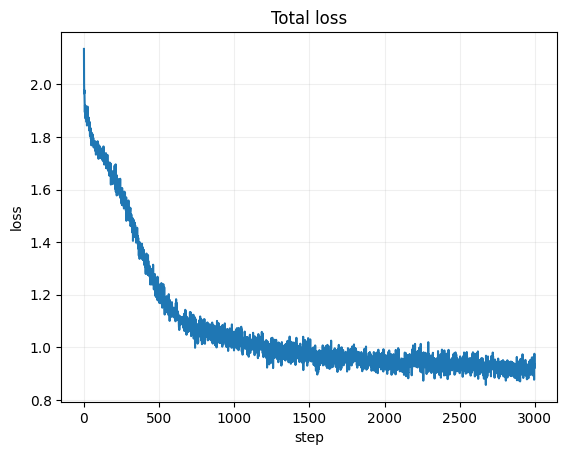

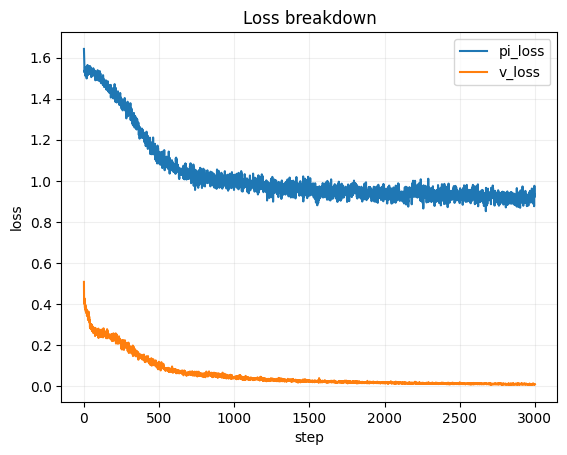

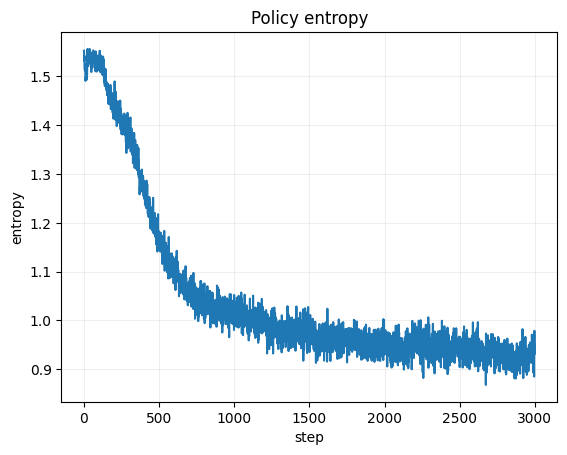

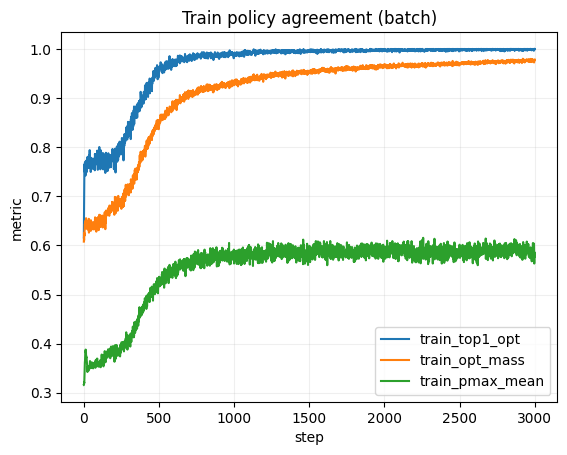

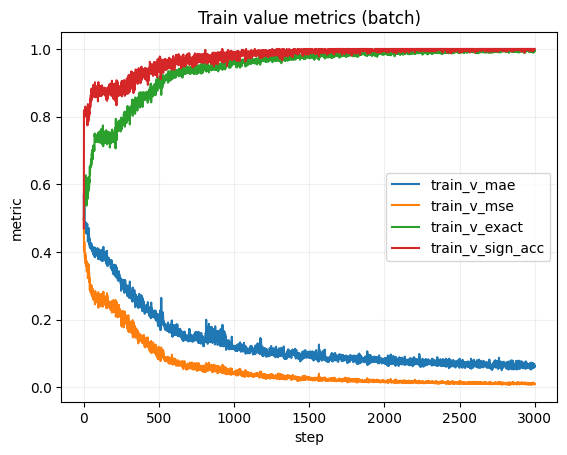

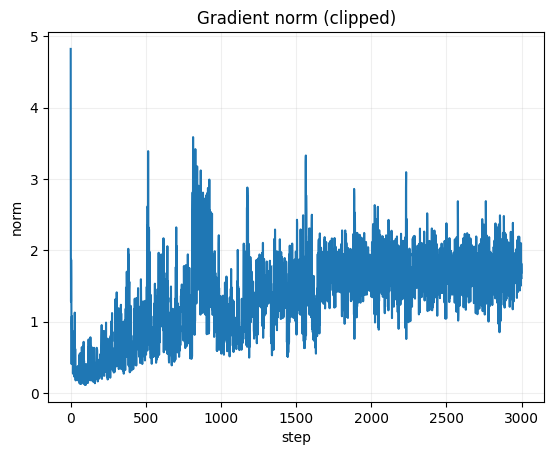

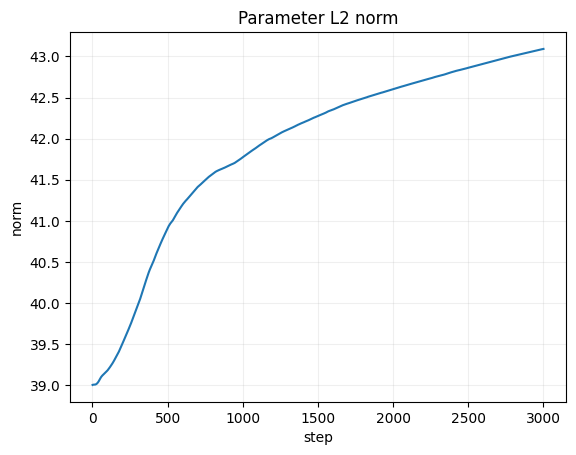

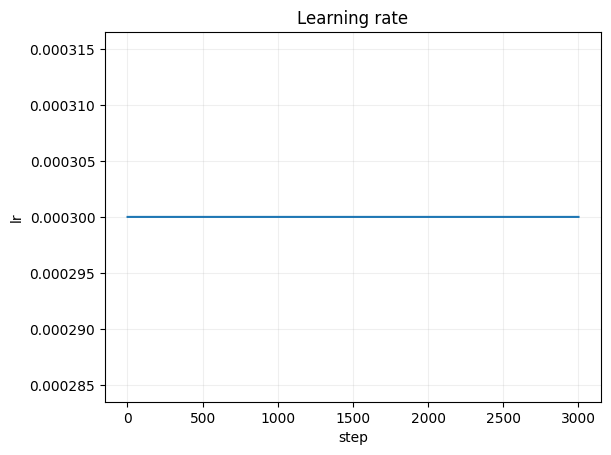

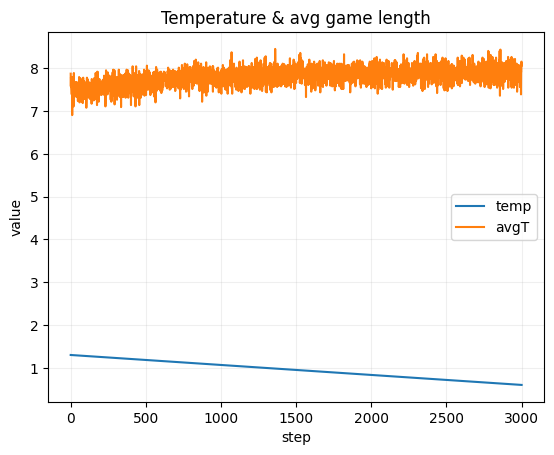

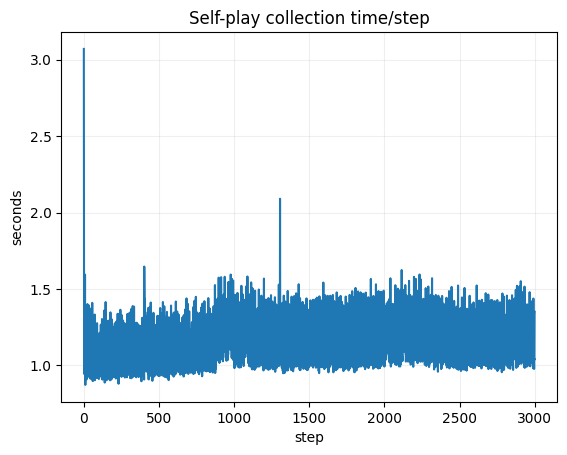

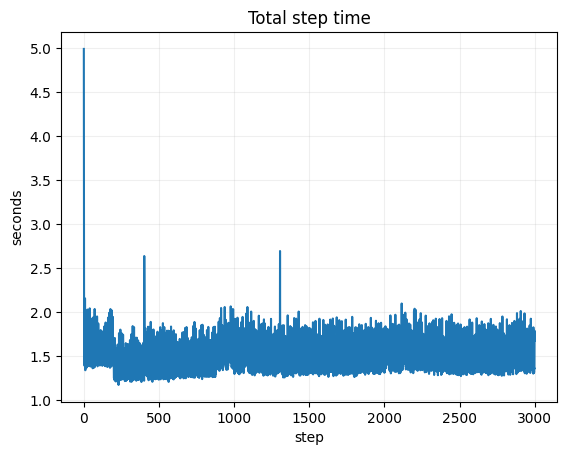

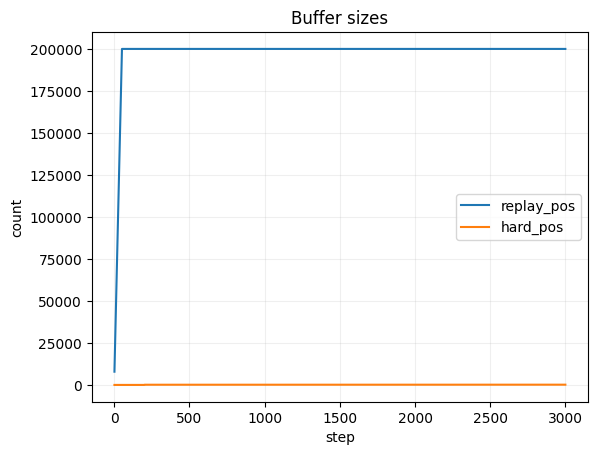

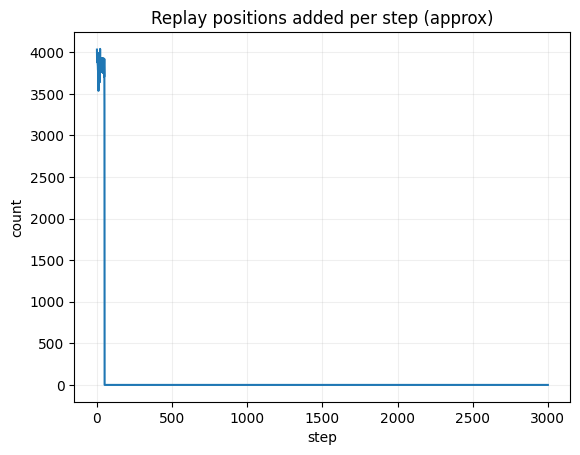

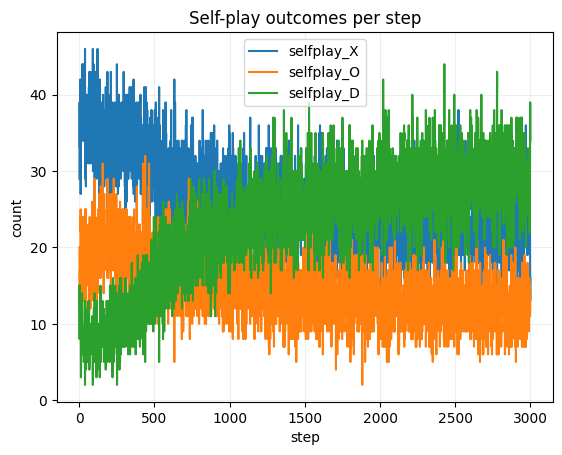

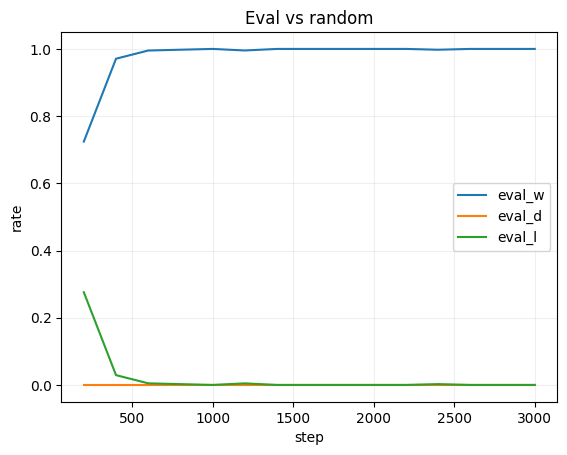

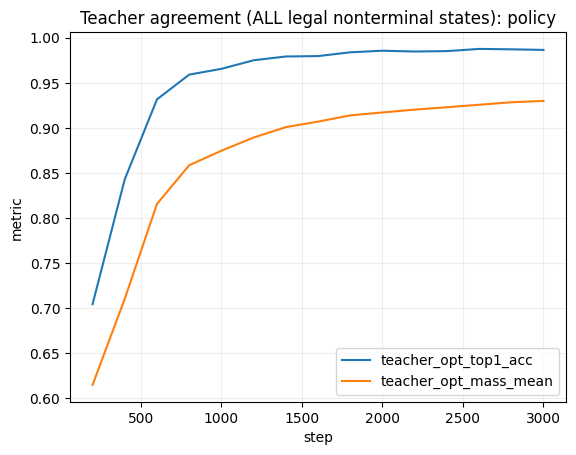

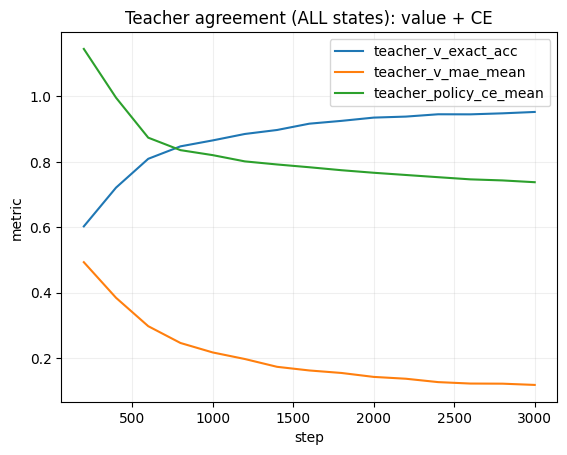

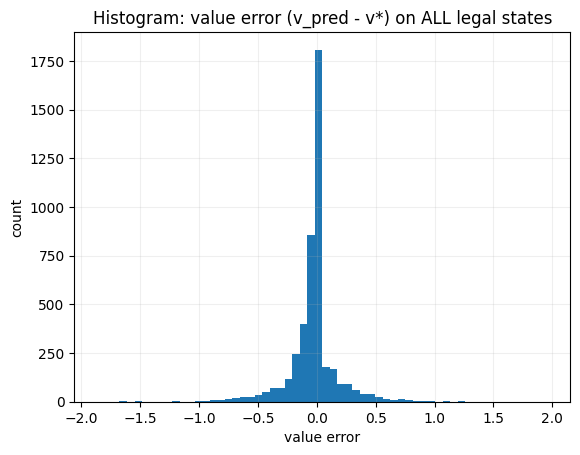

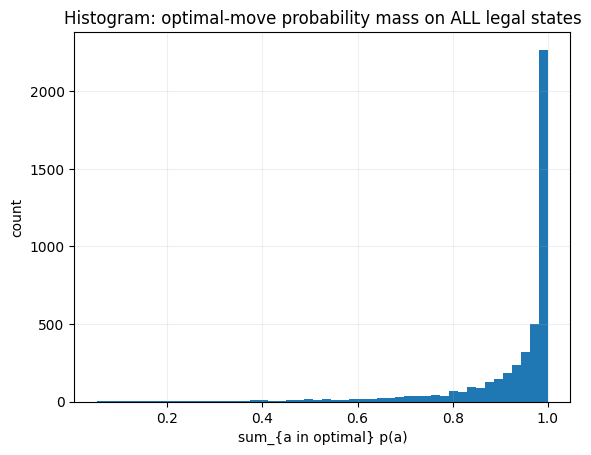

In [ ]:
model, history_df, last_teacher_eval = run_colab(
    steps=3000,            # start smaller in colab
    games_per_step=64,
    batch_size=2048,
    eval_every=200,
    teacher_eval_every=200,
    run_name="ttt_showcase",
    save_artifacts=True
)
